<a href="https://colab.research.google.com/github/iVibudh/Convolutional-Neural-Network/blob/main/Visualizing_Filters_of_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Welcome

Welcome to Visualizing Filters of a CNN using TensorFlow. This is a project-based course which should take less than 1 hours to finish. Before diving into the project, please take a look at the course objectives and structure:

##Objectives

In this course, our primary learning objective is to visualize image features that maximally activate filters of a CNN ( **VGG16 architecture** )

Visualize various filters from different layers of this network. This will help us understand:
- what those filters are looking for in the input
- help in getting a deeper understanding of Convolutional networks
- helps in using the networks for various tasks - neural style transfer

## Visualizing Filters of a Convolutional Neural Network

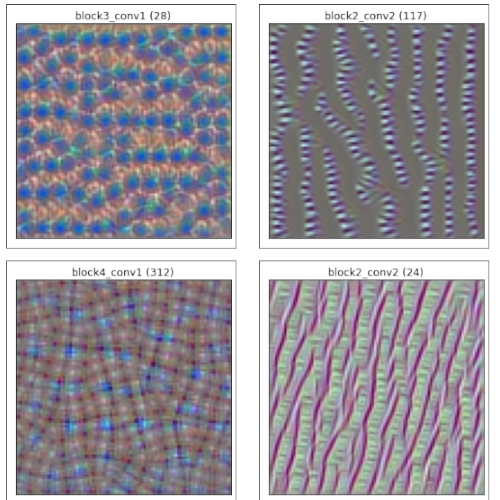


block3_conv1 (28): the imgae show maximally activates the 28th filter on the 1st convolutional layer on the 3rd block of VGG16.

## Task 2: Downloading the Model

In [3]:
import tensorflow as tf 
import random
import matplotlib.pyplot as plt

print('Tensorflow version', tf.__version__)

Tensorflow version 2.8.0


In [4]:
# getting the VGG16 model 
model = tf.keras.applications.vgg16.VGG16(
    include_top = False, # false means that the final few fully connected layers are not included in the model that we download. Since we are not doing any classifications.
    weights='imagenet', # This means that the mode with VGG16 architecture has been trained on the imagenet dataset
    input_shape= (96,96,3) # 96 rows, 96 coloumns, 3 channels
)

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

Input layer-> 2 conv layer -> 1 pooling layer-> 2 conv layer -> 1 pooling layer-> 3 conv layer -> 1 pooling layer-> 3 conv layer -> 1 pooling layer-> 3 conv layer -> 1 pooling layer

In CNN, we have a lot of simple features being learnt at the lower convolutional layers (so, block 1, 2). From 3rd block onwards more complicated patters are being learnt in the CNNs. In the 4th and 5th blocks, the patterns are going to be very complicated. 4th and 5th are the layers which are more directly impacting the classification. 

Block 1 or 2 may be sigle colour detector or a vertical line (or horizontal) detector. 

Let's try to vizualize this in this project.

## Task 3: Get Layer Output

In [5]:
# let's create a function which will give us any submodels for specific layers
# from input (start) to that particular layer  

def get_submodel(layer_name):
  return tf.keras.models.Model( #this is a model class that we are using
      model.input, # The imputs to the model
      model.get_layer(layer_name).output # Output from the last layer that we are interested in
  )

get_submodel('block1_conv2').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [10]:
submodel = get_submodel('block1_conv2')
shape = submodel.output.shape
print("Output Shape", shape)
num_filters = submodel.output.shape[-1]
print("Number of Filters that the submodel has in the output: ", num_filters)

Output Shape (None, 96, 96, 64)
Number of Filters that the submodel has in the output:  64


## Task 4: Image Visualization

Process description: We start with a random image and pass it to the network layers and then try to make modifications to the image such that the final image image features maximally activate a specific filters of the CNN. 





In [6]:
# So, first we need a way to generate the image. 
def create_image():
  """ this function creates a random image which we will be the starting point of the loop"""

  return tf.random.uniform((96,96,3), #the dimentions of a usual image
                           minval = -0.5, # we could have used any value range here, eg., between 0 and 1
                           maxval = 0.5)
  
def plot_image(image, title = 'random'):
  """ This function is used to visualize the image"""

  image = image - tf.math.reduce_min(image) # we are adding the min value to all the values. So we have no negative values
  image = image/ tf.math.reduce_max(image) # Now we scale all the values. So that all values are between 0 and 1
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

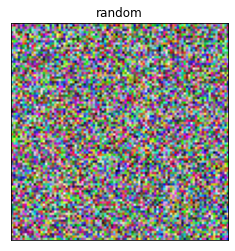

In [7]:
image = create_image()
plot_image(image)

These are the types of images that we are going to use as input when we are using the gradient descent algorithm. We will use the gradient descent algorithm to optimize the patterns which maximally activates a particular nodes of the CNN.

## Task 5: Training Loop

In [19]:
def visualize_filter(layer_name, f_index = None, iters = 50):
  ''' This function will show the image pattern (or the input) which will 
  maximally activate the filter
  
  What is the filter really looking for in the image
  
  layer_name -> we need the layer name that we want to focus on 
  f_index -> we need the index of the filter that we need to focus on in the given layer. 
  But if no value of f_index is given then we will randomly generate one of the index
  '''
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1] # get the number of filters the submodel has  

  if f_index is None: # if the index of the filter is not given then we randomly generate a filter index (in the ex above something between 0 and 63)
    f_index = random.randint(0, num_filters -1)

  assert num_filters > f_index, 'f_index is out of bounds'
  # assert - check the condition if FALSE then show the error
  
  image = create_image() # generate an input image

  verbose_step = int(iters/10) # keeping track of loss at every 10% of itterations 

  # Implement Gradient ascent algorithm 
  # In gradient descent we decent to find the minima. Here, we are trying to maximize the loss value
  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image) # watching the image in the GradientTape context

      # Now we need to pass the imgae in the submodel
      # but we need to expand the image as the model will expect a batch. Batch = 1 in this case
      # also we only need to look at the output of the filter so we take only the filter index ie. [:,:,:,f_index] 
      out = submodel(tf.expand_dims(image, axis = 0)) [:,:,:,f_index]
      loss = tf.math.reduce_mean(out) # loss is the mean of the output
    grads = tape.gradient(loss, image) # calculating the gradient - loss with respect to the image
    grads = tf.math.l2_normalize(grads) # normalize the gradient so that there are no large steps taken in any direction 
    image += grads * 10 #update the gradient - instead of decreasing the value we increase the value

    if (i + 1) % verbose_step == 0: # keeping track of loss at every 10% of itterations 
      print(f'Iteration: {i+1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')

## Task 6: Final Results

Let us see some images that maximally activates certain filters.


###Observation: 
- **Early Block filters:** The early block filters are good at observing basic features. They are looking for more simple patterns such as colour, lines, etc. 
- **Later Block Filters:** Whereas later block filters are looking at more complicated patters. The filters are maximally activated by more and more complex features.
- **Note:** Sometimes even for later block filters, you may observe that the images generated are very random. You might want to look at loss values here. It might be the case that these filters are not activated much and might not have a huge impact in making the decisions.

In [20]:
# lets look at all the convolutional layers
print([layer.name for layer in model.layers if 'conv' in layer.name])

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


Iteration: 5, Loss: 1.8695
Iteration: 10, Loss: 3.3677
Iteration: 15, Loss: 4.8660
Iteration: 20, Loss: 6.3642
Iteration: 25, Loss: 7.8624
Iteration: 30, Loss: 9.3607
Iteration: 35, Loss: 10.8589
Iteration: 40, Loss: 12.3572
Iteration: 45, Loss: 13.8554
Iteration: 50, Loss: 15.3537


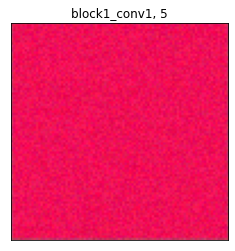

In [25]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block1_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, 5, iters = 50)

Iteration: 10, Loss: 1.2945
Iteration: 20, Loss: 2.2751
Iteration: 30, Loss: 3.3350
Iteration: 40, Loss: 4.4334
Iteration: 50, Loss: 5.5524
Iteration: 60, Loss: 6.6879
Iteration: 70, Loss: 7.8333
Iteration: 80, Loss: 8.9875
Iteration: 90, Loss: 10.1476
Iteration: 100, Loss: 11.3126


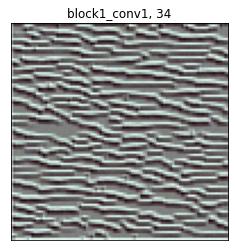

In [26]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block1_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters = 100)

Iteration: 10, Loss: 28.5988
Iteration: 20, Loss: 50.3046
Iteration: 30, Loss: 72.1677
Iteration: 40, Loss: 94.1819
Iteration: 50, Loss: 116.2945
Iteration: 60, Loss: 138.4453
Iteration: 70, Loss: 160.6371
Iteration: 80, Loss: 182.8806
Iteration: 90, Loss: 205.1615
Iteration: 100, Loss: 227.4764


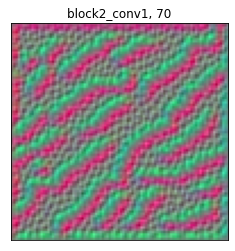

In [27]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block2_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters = 100)

Iteration: 10, Loss: 67.6144
Iteration: 20, Loss: 135.2642
Iteration: 30, Loss: 214.2691
Iteration: 40, Loss: 303.3195
Iteration: 50, Loss: 396.2254
Iteration: 60, Loss: 491.0068
Iteration: 70, Loss: 586.8655
Iteration: 80, Loss: 683.3660
Iteration: 90, Loss: 780.3372
Iteration: 100, Loss: 877.7173


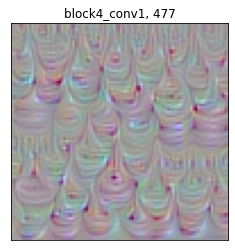

In [31]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block4_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters = 100)

Iteration: 10, Loss: 27.8641
Iteration: 20, Loss: 54.1783
Iteration: 30, Loss: 81.7718
Iteration: 40, Loss: 112.1245
Iteration: 50, Loss: 146.8801
Iteration: 60, Loss: 188.3462
Iteration: 70, Loss: 234.9032
Iteration: 80, Loss: 284.2760
Iteration: 90, Loss: 337.2556
Iteration: 100, Loss: 391.6205


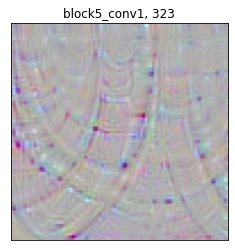

In [28]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block5_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters = 100)

Iteration: 5, Loss: 10.1546
Iteration: 10, Loss: 18.2561
Iteration: 15, Loss: 27.5164
Iteration: 20, Loss: 34.9772
Iteration: 25, Loss: 43.1940
Iteration: 30, Loss: 52.0856
Iteration: 35, Loss: 60.3046
Iteration: 40, Loss: 69.8028
Iteration: 45, Loss: 79.8331
Iteration: 50, Loss: 89.6184


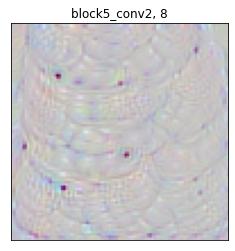

In [30]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block5_conv2' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters = 50)

Iteration: 10, Loss: 25.1425
Iteration: 20, Loss: 54.3129
Iteration: 30, Loss: 88.6497
Iteration: 40, Loss: 127.4542
Iteration: 50, Loss: 167.9543
Iteration: 60, Loss: 212.3933
Iteration: 70, Loss: 260.8339
Iteration: 80, Loss: 312.2694
Iteration: 90, Loss: 366.1271
Iteration: 100, Loss: 421.5963


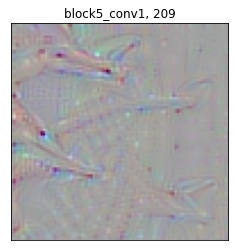

In [33]:
# use colab parameters to take input as one of the convolutional layers
# colab parameter creates a dropdown
layer_name = 'block5_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, 209, iters = 100)